### Importing Libraries

In [1]:
# basics
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing

from sklearn.preprocessing import StandardScaler,MinMaxScaler,binarize

#model selection
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV

#model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier

#metrics
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score,roc_curve,accuracy_score

#feature selection
from sklearn.feature_selection import SelectKBest,chi2

#warnings
import warnings as ws
ws.filterwarnings('ignore')

### Importing Data

In [2]:
note=pd.read_csv('BankNote_Authentication.csv')
note.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


### Checking the shape of data number of rows and column

In [3]:
#Shape of data
note.shape

(1372, 5)

here we see that data has total 5  columns and 1372 rows

### Checking null values in data

In [4]:
note.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

There is no null values or missing values in data 

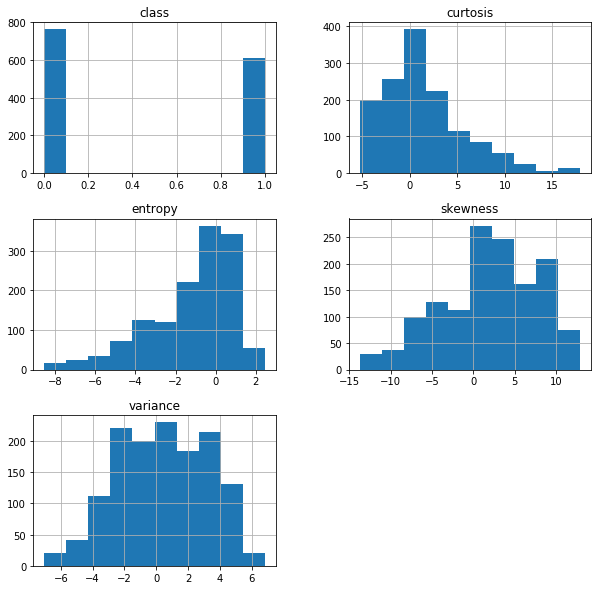

In [5]:
note.hist(figsize=(10,10))
plt.show()

From above histogram of each columns of data we see that class has only two values 0 and 1. 
Now let's see the all the terms reading with the class column.

In [6]:
#dropping column 'class'
note_col=note.drop('class',axis=1).columns.tolist()


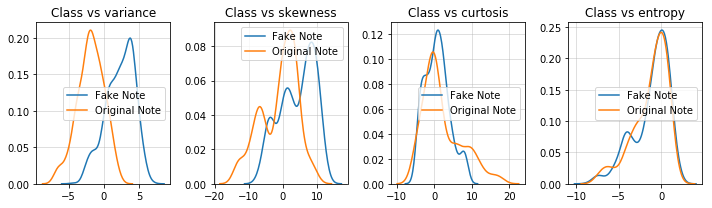

In [7]:
plt.figure(figsize=(10,3))
i=0
for col in note_col:
    plt.subplot(1,4,i+1)
    plt.grid(True,alpha=0.5)
    sns.kdeplot(note[col][note['class']==0],label='Fake Note')
    sns.kdeplot(note[col][note['class']==1],label='Original Note')
    plt.title('Class vs '+ col)
    plt.tight_layout()
    i+=1
plt.show()

### Splitting dataset

In [8]:
X=note.drop('class',axis=1)
Y=note['class']

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=7)

In [9]:
#model
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier()))
models.append(('ADA',AdaBoostClassifier()))
models.append(('GB',GradientBoostingClassifier()))

In [10]:
# creating function fo rmodel selection
def model_selection(x_train,y_train):
    acc_result=[]
    auc_result=[]
    names=[]
    col=['Model','ROC AUC Mean','ROC AUC Std','ACC Mean','ACC Std']
    result=pd.DataFrame(columns=col)
    i=0
    for name,model in models:
        kfold=KFold(n_splits=10,random_state=7)
        cv_acc_result=cross_val_score(model,x_train,y_train,cv=kfold,scoring='accuracy')
        cv_auc_result=cross_val_score(model,x_train,y_train,cv=kfold,scoring='roc_auc')
        acc_result.append(cv_acc_result)
        auc_result.append(cv_auc_result)
        names.append(name)
        result.loc[i]=[name,cv_auc_result.mean(),cv_auc_result.std(),cv_acc_result.mean(),cv_acc_result.std()]
        result=result.sort_values('ROC AUC Mean',ascending=False)
        i+=1
        
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.boxplot(x=names,y=auc_result)
    plt.title('ROC AUC Score')
        
    plt.subplot(1,2,2)
    sns.boxplot(x=names,y=acc_result)
    plt.title('Accuracy Score')
    plt.show()
    return(result)

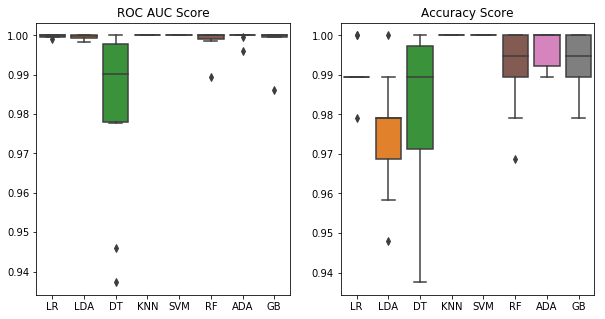

,Model,ROC AUC Mean,ROC AUC Std,ACC Mean,ACC Std
3,KNN,1.000000,0.000000,1.000000,0.000000
4,SVM,1.000000,0.000000,1.000000,0.000000
0,LR,0.999822,0.000294,0.990625,0.005610
6,ADA,0.999563,0.001165,0.996875,0.004774
1,LDA,0.999518,0.000599,0.975000,0.014130
5,RF,0.998663,0.003079,0.991667,0.010206
7,GB,0.998515,0.004157,0.992708,0.008136
2,DT,0.981095,0.021212,0.981250,0.019654


In [11]:
model_selection(x_train,y_train)

From above model selection we realise that KNN is the best model for this dataset 

In [18]:
def model_validation(model,x_test,y_test,thr=0.5):
    y_pred_prob=model.predict_proba(x_test)[:,1]
    y_pred=binarize(y_pred_prob.reshape(1,-1),thr)[0]
    cnf_matrix=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,3))
    sns.heatmap(cnf_matrix,annot=True,fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    fpr,tpr,threshold=roc_curve(y_test,y_pred_prob)
    plt.subplot(1,2,2)
    sns.lineplot(fpr,tpr)
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Psitive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print('Classification Report:')
    print('==='*20)
    print(classification_report(y_test,y_pred))
    
    score=tpr-fpr
    opt_threshold=sorted(zip(score,threshold))[-1][1]
    print('='*20)
    print('Area Under Curve',roc_auc_score(y_test,y_pred))
    print('Accuracy',accuracy_score(y_test,y_pred))
    print('Optimal threshold:',opt_threshold)
    print('='*20)

In [19]:
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
param_grid={
    'leaf_size':[2,5,7,9,11],
    'n_neighbors':[2,5,7,9,11],
    'p':[1,2]
}

grid=GridSearchCV(KNeighborsClassifier(),param_grid)
grid.fit(x_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'leaf_size': [2, 5, 7, 9, 11], 'n_neighbors': [2, 5, 7, 9, 11], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
grid.best_params_

{'leaf_size': 2, 'n_neighbors': 2, 'p': 1}

In [22]:
final_model=grid.best_estimator_

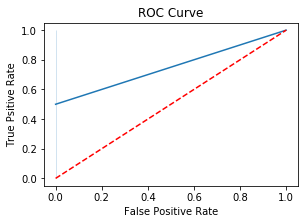

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       172

   micro avg       1.00      1.00      1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412

Area Under Curve 1.0
Accuracy 1.0
Optimal threshold: 1.0


In [23]:
model_validation(final_model,x_test,y_test)